# LAB 5. Hypothesis testing. Green taxi case

Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2018-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [133]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [134]:
#create the folders
if not os.path.exists('Data'):
    os.mkdir('Data')
if not os.path.exists('Data/TLC'):
    os.mkdir('Data/TLC')

In [135]:
# Download green taxi data if not downloaded yet; might take a couple of minutes
for year in [2018, 2019, 2020]:
    for month in range(1, 13):
        if year == 2020 and month > 6:
            pass
        else:
            parquet_file = f'green_tripdata_{year}-{str(month).zfill(2)}.parquet'
            csv_file = f'green_tripdata_{year}-{str(month).zfill(2)}.csv'
            if not os.path.exists(f'Data/TLC/{csv_file}'):
                url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/{parquet_file}'
                parquet_path = f'Data/TLC/{parquet_file}'
                csv_path = f'Data/TLC/{csv_file}'
                
                # Download the parquet file
                urllib.request.urlretrieve(url, parquet_path)
                
                # Convert parquet to csv
                df = pd.read_parquet(parquet_path)
                df.to_csv(csv_path, index=False)
                
                # Optionally, remove the parquet file
                os.remove(parquet_path)

print('done')

done


In [136]:
#concatenate all the files into a single dataframe - takes up to a minute
files = os.listdir('./Data/TLC/')
dfList = []

for index,filename in enumerate(files):
    if '.csv' in filename:
        if index == 0:
            df = pd.read_csv('./Data/TLC/'+filename, index_col=None)
        else:
            df = pd.read_csv('./Data/TLC/'+filename, index_col=None, header=0)
        dfList.append(df)
dfTaxi = pd.concat(dfList, axis=0, ignore_index=True)

In [137]:
dfTaxi.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [138]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [139]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2018,2019,2020])]

In [140]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [141]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hoiur

In [142]:
len(dfTaxi) #original number of records

16426014

In [143]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2020')) & (dfTaxi.trip_distance < 100)
           & (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

15881382

In [144]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [145]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [146]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017


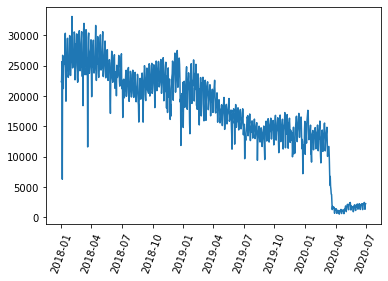

In [147]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

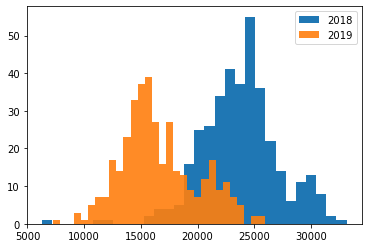

In [148]:
#histograms of daily counts in 2019 and 2018 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'].values,bins=30,label='2018')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,alpha=0.9,label='2019')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()

In [149]:
## t-test between the 2019 and 2018 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

Ttest_indResult(statistic=28.657087941915258, pvalue=1.666456504219968e-121)

In [150]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

KstestResult(statistic=0.7287671232876712, pvalue=3.569826213988359e-94)

So the hypothesis that 2018 and 2019 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [151]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(6050642, 6050642)

## Example 1. Test if weekend ridership is different from weekday

In [152]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

Ttest_indResult(statistic=-2.451880479058623, pvalue=0.014760749788942986)

In [153]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

KstestResult(statistic=0.19773647405226352, pvalue=0.007623489458232213)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

<AxesSubplot:>

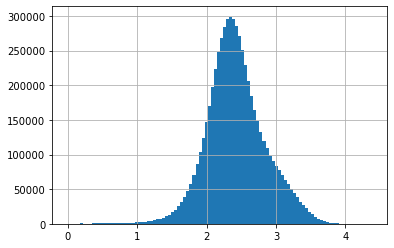

In [154]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)

<AxesSubplot:>

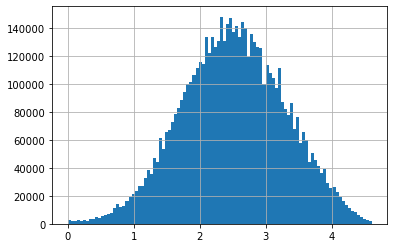

In [155]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)

<AxesSubplot:>

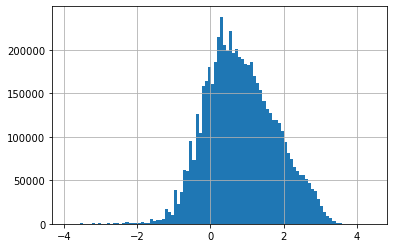

In [156]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)

In [157]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [158]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.041124214393331915, pvalue=0.0)

In [159]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.009910381707666005, pvalue=0.0)

In [160]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.03805199190988168, pvalue=0.0)

In [161]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [162]:
#what about daily average trip_count, duration, distance, speed?

In [163]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.08978473661157738, pvalue=0.0052026892522868615)

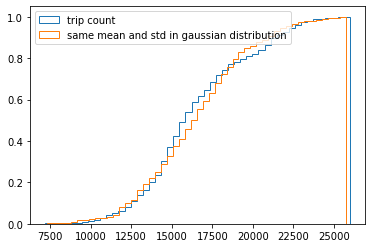

In [164]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [165]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.05176889942437657, pvalue=0.27245276442567923)

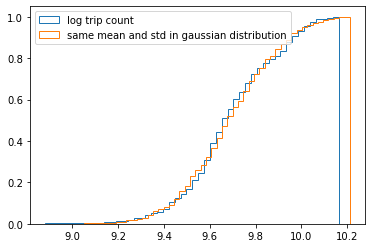

In [166]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [167]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.08629102051381854, pvalue=0.008181442632357832)

<AxesSubplot:>

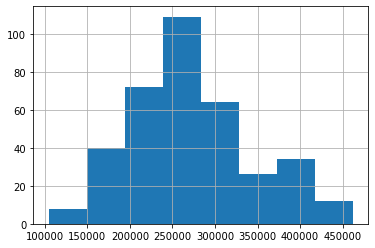

In [168]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

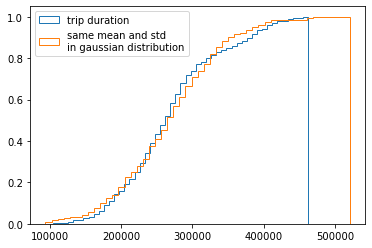

In [169]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')

In [170]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.17163545001482727, pvalue=7.163182264727073e-10)

In [171]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.12271548280910827, pvalue=3.0054477785862917e-05)

In [172]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.07628804961462687, pvalue=0.02707330147991338)

In [173]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.06791252706897999, pvalue=0.06584459147143584)

## Homework assignment

## Task 1. Travel speed - hours of the day
Traffic and travel speed might vary throughout the day. Select the trips happening on Oct, 1, 2019. a) Compute average travel speed per each hour of the day and visuale as a bar plot. Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am, c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)). Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95\% significance level?

In [174]:
#a)
dfTaxia = dfTaxi[dfTaxi['Date']==pd.to_datetime('10/1/2019')]
dfTaxia.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
13760139,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,1.516667,14.241758
13760341,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,10.450000,16.363636
13760379,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,1.0,1.0,0.0,2019-10-01,10,2019,1,0,5.750000,12.626087
13819523,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,13.933333,25.320574
13819524,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,2.0,1.0,0.0,2019-10-01,10,2019,1,0,4.450000,10.786517


In [175]:
dfTaxiabh = dfTaxia.groupby(['Hour']).agg({'trip_duration':'sum','trip_distance':'sum'}).reset_index()
dfTaxiabh['avg speed by hours']=dfTaxiabh['trip_distance']/(dfTaxiabh['trip_duration']/60)

<AxesSubplot:>

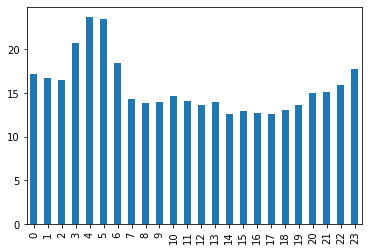

In [176]:
dfTaxiabh['avg speed by hours'].plot.bar()

In [177]:
#b)

In [178]:
dfTaxia9=dfTaxia[dfTaxia['Hour']==9]
dfTaxia10=dfTaxia[dfTaxia['Hour']==10]
dfTaxia9['speed'] = dfTaxia9['trip_distance'] / dfTaxia9['trip_duration'] * 60
dfTaxia10['speed'] = dfTaxia10['trip_distance'] / dfTaxia10['trip_duration'] * 60

<AxesSubplot:>

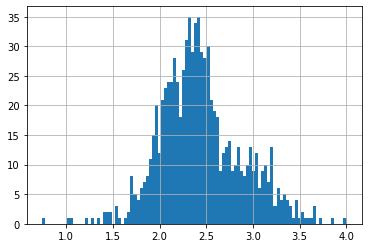

In [179]:
np.log(dfTaxia9['speed']).hist(bins=100)

In [180]:
is_normal(dfTaxia9['speed'])

KstestResult(statistic=0.16711176232448666, pvalue=5.673693234692725e-21)

<AxesSubplot:>

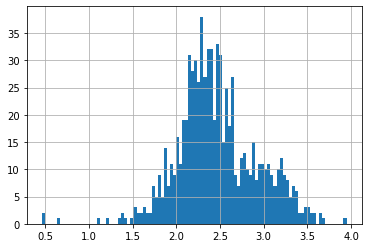

In [181]:
np.log(dfTaxia10['speed']).hist(bins=100)

In [182]:
is_normal(dfTaxia10['speed'])

KstestResult(statistic=0.15864276063837845, pvalue=1.004844248436056e-17)

In [183]:
#c)

In [184]:
dfTaxiaMRH=dfTaxia.loc[dfTaxia['Hour'].isin([8,9])]
dfTaxiaERH=dfTaxia.loc[dfTaxia['Hour'].isin([17,18])]

In [185]:
dfTaxiaMRH['speed']=dfTaxiaMRH['trip_distance'] / dfTaxiaMRH['trip_duration'] * 60
dfTaxiaERH['speed']=dfTaxiaERH['trip_distance'] / dfTaxiaERH['trip_duration'] * 60

In [186]:
dfTaxiaMRH

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
13820007,2,2019-10-01 08:37:38,2019-10-01 08:38:38,N,1.0,42,42,1.0,0.26,3.00,...,2.0,1.0,0.00,2019-10-01,10,2019,1,8,1.000000,15.600000
13820008,2,2019-10-01 08:40:57,2019-10-01 09:14:54,N,1.0,41,234,1.0,5.27,23.50,...,1.0,1.0,2.75,2019-10-01,10,2019,1,8,33.950000,9.313697
13820367,2,2019-10-01 08:00:06,2019-10-01 08:34:41,N,1.0,66,66,5.0,9.83,33.00,...,1.0,1.0,2.75,2019-10-01,10,2019,1,8,34.583333,17.054458
13820407,2,2019-10-01 08:01:21,2019-10-01 08:06:11,N,1.0,42,41,1.0,0.84,5.50,...,1.0,1.0,0.00,2019-10-01,10,2019,1,8,4.833333,10.427586
13820429,2,2019-10-01 08:01:45,2019-10-01 08:13:53,N,1.0,7,145,1.0,2.69,11.00,...,1.0,1.0,0.00,2019-10-01,10,2019,1,8,12.133333,13.302198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207089,2,2019-10-01 09:47:00,2019-10-01 10:21:00,NaN,NaN,127,231,NaN,12.92,43.72,...,NaN,NaN,NaN,2019-10-01,10,2019,1,9,34.000000,22.800000
14207090,2,2019-10-01 09:34:00,2019-10-01 10:07:00,NaN,NaN,85,55,NaN,6.74,39.75,...,NaN,NaN,NaN,2019-10-01,10,2019,1,9,33.000000,12.254545
14207091,2,2019-10-01 09:31:00,2019-10-01 09:59:00,NaN,NaN,42,229,NaN,6.60,21.72,...,NaN,NaN,NaN,2019-10-01,10,2019,1,9,28.000000,14.142857
14207092,2,2019-10-01 09:44:00,2019-10-01 10:04:00,NaN,NaN,89,181,NaN,3.43,21.44,...,NaN,NaN,NaN,2019-10-01,10,2019,1,9,20.000000,10.290000


In [187]:
dfTaxiaERH

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,trip_duration,speed
13820144,2,2019-10-01 17:39:51,2019-10-01 17:48:08,N,1.0,223,179,1.0,1.34,7.50,...,1.0,1.0,0.0,2019-10-01,10,2019,1,17,8.283333,9.706237
13820277,2,2019-10-01 18:24:14,2019-10-01 18:30:59,N,1.0,223,223,1.0,1.54,7.00,...,2.0,1.0,0.0,2019-10-01,10,2019,1,18,6.750000,13.688889
13820278,2,2019-10-01 18:39:58,2019-10-01 18:45:27,N,1.0,223,223,1.0,0.87,5.50,...,2.0,1.0,0.0,2019-10-01,10,2019,1,18,5.483333,9.519757
13826350,2,2019-10-01 17:03:38,2019-10-01 17:39:01,N,1.0,173,82,1.0,3.11,21.00,...,2.0,1.0,0.0,2019-10-01,10,2019,1,17,35.383333,5.273669
13826383,2,2019-10-01 17:02:47,2019-10-01 17:13:22,N,1.0,129,7,1.0,1.57,9.00,...,2.0,1.0,0.0,2019-10-01,10,2019,1,17,10.583333,8.900787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14208385,2,2019-10-01 18:28:00,2019-10-01 18:48:00,NaN,NaN,254,119,NaN,6.92,23.01,...,NaN,NaN,NaN,2019-10-01,10,2019,1,18,20.000000,20.760000
14208386,2,2019-10-01 18:40:00,2019-10-01 19:04:00,NaN,NaN,168,131,NaN,14.78,42.74,...,NaN,NaN,NaN,2019-10-01,10,2019,1,18,24.000000,36.950000
14208387,2,2019-10-01 18:14:00,2019-10-01 18:42:00,NaN,NaN,17,76,NaN,6.01,26.63,...,NaN,NaN,NaN,2019-10-01,10,2019,1,18,28.000000,12.878571
14208388,2,2019-10-01 18:36:00,2019-10-01 18:50:00,NaN,NaN,69,18,NaN,3.45,23.01,...,NaN,NaN,NaN,2019-10-01,10,2019,1,18,14.000000,14.785714


In [188]:
stats.ttest_ind(dfTaxiaMRH['speed'],dfTaxiaERH['speed'])

Ttest_indResult(statistic=5.316218844376528, pvalue=1.1253493376433041e-07)

In [189]:
stats.ks_2samp(dfTaxiaMRH['speed'],dfTaxiaERH['speed'])

KstestResult(statistic=0.06860517517057287, pvalue=0.0005164093592973096)

In [190]:
#t-test pvalue=1.1253493376433041e-07 and below 0.05, ks-test pvalue=0.0005164093592973096 and below 0.05.
#reject the hypothesis that the compared speed samples have the same mean and distribution at a 95% significance level

## Task 2. Travel speed - days of the week
Traffic and travel speed also vary during different weekdays. a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute average travel speed per each day of the year and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [191]:
#a)
dfTaxib=dfTaxi.groupby(['DOW']).agg({'trip_distance':'sum','trip_duration':'sum'}).reset_index()
dfTaxib['avg_speed']=dfTaxib['trip_distance']/dfTaxib['trip_duration']*60

<AxesSubplot:>

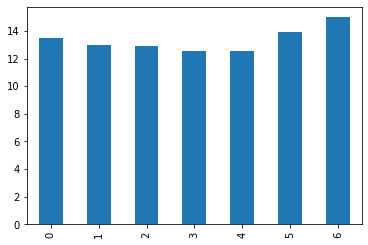

In [192]:
dfTaxib['avg_speed'].plot.bar()

In [193]:
dfTaxic=dfTaxi.groupby(['Date']).agg({'trip_distance':'sum','trip_duration':'sum'}).reset_index()
dfTaxic['avg_speed']=dfTaxic['trip_distance']/dfTaxic['trip_duration']*60

In [194]:
dfTaxic['Date']=pd.to_datetime(dfTaxic['Date'])
dfTaxic['DOW'] = dfTaxic['Date'].dt.dayofweek
dfTaxic

,Date,trip_distance,trip_duration,avg_speed,DOW
0,2018-01-01,67911.34,263853.966667,15.442938,0
1,2018-01-02,59493.64,274362.416667,13.010595,1
2,2018-01-03,69394.22,341670.100000,12.186180,2
3,2018-01-04,16403.10,80896.516667,12.165987,3
4,2018-01-05,64290.25,341303.233333,11.302017,4
...,...,...,...,...,...
907,2020-06-26,12314.68,45874.233333,16.106663,4
908,2020-06-27,7642.07,25746.750000,17.809013,5
909,2020-06-28,6713.17,20931.033333,19.243684,6
910,2020-06-29,11496.92,40750.166667,16.927911,0


In [195]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==0]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==1]['avg_speed'])#R

KstestResult(statistic=0.24427480916030533, pvalue=0.0007673093828356342)

In [196]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==0]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==2]['avg_speed'])#R

KstestResult(statistic=0.3015267175572519, pvalue=1.0920804697001074e-05)

In [197]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==0]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==3]['avg_speed'])#R

KstestResult(statistic=0.4467997651203758, pvalue=3.5125236053090703e-12)

In [198]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==0]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==4]['avg_speed'])#R

KstestResult(statistic=0.46218438050499117, pvalue=4.943823128655822e-13)

In [199]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==0]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==5]['avg_speed'])#R

KstestResult(statistic=0.3126247798003523, pvalue=3.1095316831430964e-06)

In [200]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==0]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==6]['avg_speed'])#R

KstestResult(statistic=0.6409277745155608, pvalue=6.661338147750939e-16)

In [201]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==1]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==2]['avg_speed'])#Keep

KstestResult(statistic=0.09530240751614798, pvalue=0.5495770947538914)

In [202]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==1]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==3]['avg_speed'])#R

KstestResult(statistic=0.27803875513799176, pvalue=6.672903398485808e-05)

In [203]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==1]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==4]['avg_speed'])#R

KstestResult(statistic=0.2630651790957134, pvalue=0.0001994605984404485)

In [204]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==1]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==5]['avg_speed'])#R

KstestResult(statistic=0.4805049911920141, pvalue=2.2426505097428162e-14)

In [205]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==1]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==6]['avg_speed'])#R

KstestResult(statistic=0.7631826189078097, pvalue=6.661338147750939e-16)

In [206]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==2]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==3]['avg_speed'])#R

KstestResult(statistic=0.23076923076923078, pvalue=0.0019008874893625732)

In [207]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==2]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==4]['avg_speed'])#R

KstestResult(statistic=0.2153846153846154, pvalue=0.004694096040382525)

In [208]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==2]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==5]['avg_speed'])#R

KstestResult(statistic=0.5461538461538461, pvalue=3.804591308996931e-18)

In [209]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==2]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==6]['avg_speed'])#R

KstestResult(statistic=0.7615384615384615, pvalue=3.0153638487100635e-37)

In [210]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==3]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==4]['avg_speed'])#Keep

KstestResult(statistic=0.046153846153846156, pvalue=0.9991792228558725)

In [211]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==3]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==5]['avg_speed'])#R

KstestResult(statistic=0.6307692307692307, pvalue=1.4233332297193913e-24)

In [212]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==3]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==6]['avg_speed'])#R

KstestResult(statistic=0.8, pvalue=9.148352419693812e-42)

In [213]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==4]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==5]['avg_speed'])#R

KstestResult(statistic=0.6307692307692307, pvalue=1.4233332297193913e-24)

In [214]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==4]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==6]['avg_speed'])#R

KstestResult(statistic=0.8, pvalue=9.148352419693812e-42)

In [215]:
stats.ks_2samp(dfTaxic.loc[dfTaxic['DOW']==5]['avg_speed'],dfTaxic.loc[dfTaxic['DOW']==6]['avg_speed'])#R

KstestResult(statistic=0.5461538461538461, pvalue=3.804591308996931e-18)

In [216]:
DOW=dfTaxic['DOW']

In [217]:
newdf = pd.DataFrame(index=DOW.unique(), columns=DOW.unique())

In [218]:
for i in DOW.unique():
    for j in DOW.unique():
        if i==j:
            newdf.loc[i,j]='-  '
        else:
            data1 = dfTaxic[dfTaxic['DOW'] == i]['avg_speed']
            data2 = dfTaxic[dfTaxic['DOW'] == j]['avg_speed']
            _, pvalue = stats.ks_2samp(data1, data2)
            if pvalue>=0.05:
                newdf.loc[i,j]='keep '
            else:
                newdf.loc[i,j]='reject'
                

In [219]:
print(newdf)

        0       1       2       3       4       5       6
0     -    reject  reject  reject  reject  reject  reject
1  reject     -     keep   reject  reject  reject  reject
2  reject   keep      -    reject  reject  reject  reject
3  reject  reject  reject     -     keep   reject  reject
4  reject  reject  reject   keep      -    reject  reject
5  reject  reject  reject  reject  reject     -    reject
6  reject  reject  reject  reject  reject  reject     -  


## Task 3. Trip speeds per borough.

For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup). Then compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison). Fill two 3x3 pandas dataframes (one for t-test, one for ks-test) with p-values for each pair of boroughs. Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is is similar?

HINT: Download taxizone geojson from 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON' to define borough for each pickup taxi zone.

In [220]:
# download taxizone map
file = 'taxizone.geojson'
url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'
urllib.request.urlretrieve(url,'Data/TLC/'+file)

('Data/TLC/taxizone.geojson', <http.client.HTTPMessage at 0x29173ea90a0>)

In [221]:
geomap = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON')

dfTaxi_2019 = dfTaxi[dfTaxi['Date'] == pd.to_datetime('10/1/2019')]

In [222]:
dfTaxi_2019['location_id'] = dfTaxi_2019['PULocationID'].astype(str)
ndf = pd.merge(dfTaxi_2019 , geomap, left_on='location_id', right_on='location_id', how='left')


In [223]:
borough_speed = ndf[ndf['borough'].isin(['Brooklyn', 'Queens', 'Bronx'])].groupby('borough')['trip_duration','trip_distance'].sum()
borough_speed['avg_speed']=borough_speed['trip_distance']/borough_speed['trip_duration']*60
borough_speed

,trip_duration,trip_distance,avg_speed
borough,,,
Bronx,21668.050000,6101.52,16.895438
Brooklyn,68969.366667,15933.62,13.861476
Queens,51916.833333,12954.61,14.971572


In [224]:
ndf_BX= ndf[ndf['borough']=='Bronx']
ndf_BK= ndf[ndf['borough']=='Brooklyn']
ndf_QS= ndf[ndf['borough']=='Queens']

In [225]:
stats.ttest_ind(ndf_BX['speed'],ndf_BK['speed'])#R

Ttest_indResult(statistic=12.658486361340884, pvalue=3.8346516391397284e-36)

In [226]:
stats.ttest_ind(ndf_BX['speed'],ndf_QS['speed'])#R

Ttest_indResult(statistic=6.815819334302827, pvalue=1.0587102508503335e-11)

In [227]:
stats.ttest_ind(ndf_BK['speed'],ndf_QS['speed'])#R

Ttest_indResult(statistic=-8.081343504522616, pvalue=7.438515878530461e-16)

In [228]:
borough=['Brooklyn', 'Queens', 'Bronx']
nndf=ndf[ndf['borough'].isin(['Brooklyn', 'Queens', 'Bronx'])]
ttest=pd.DataFrame(index=borough, columns=borough)
ks=pd.DataFrame(index=borough, columns=borough)

In [229]:
for i in range(3):
    for j in range(3):
        if i == j:
            ttest.loc[borough[i],borough[j]] = '-'
        else:
            data1 = nndf[nndf['borough'] == borough[i]]['speed']
            data2 = nndf[nndf['borough'] == borough[j]]['speed']
            _, pvalue = stats.ttest_ind(data1, data2)
            ttest.loc[borough[i],borough[j]] = str(pvalue)

In [230]:
ttest#we can reject the null hypothesis that speed mean within each pair of boroughs is similar

,Brooklyn,Queens,Bronx
Brooklyn,-,7.438515878530461e-16,3.8346516391397284e-36
Queens,7.438515878530461e-16,-,1.0587102508503335e-11
Bronx,3.8346516391397284e-36,1.0587102508503335e-11,-


In [231]:
stats.ks_2samp(ndf_BX['speed'],ndf_BK['speed'])#R

KstestResult(statistic=0.23025183728592324, pvalue=1.887379141862766e-15)

In [232]:
stats.ks_2samp(ndf_BX['speed'],ndf_QS['speed'])#R

KstestResult(statistic=0.13433446846476785, pvalue=6.932232565759477e-13)

In [233]:
stats.ks_2samp(ndf_BK['speed'],ndf_QS['speed'])#R

KstestResult(statistic=0.11322274699742486, pvalue=7.588900499927009e-21)

In [234]:
for i in range(3):
    for j in range(3):
        if i == j:
            ks.loc[borough[i],borough[j]] = '-'
        else:
            data1 = nndf[nndf['borough'] == borough[i]]['speed']
            data2 = nndf[nndf['borough'] == borough[j]]['speed']
            _, pvalue = stats.ks_2samp(data1, data2)
            ks.loc[borough[i],borough[j]] = str(pvalue)

In [235]:
ks#we can reject the null hypothesis that speed distributions within each pair of boroughs is similar

,Brooklyn,Queens,Bronx
Brooklyn,-,7.588900499927009e-21,1.887379141862766e-15
Queens,7.588900499927009e-21,-,6.932232565759477e-13
Bronx,1.887379141862766e-15,6.932232565759477e-13,-


In [236]:
#p-values all below 0.05, so we can reject the null hypothesis that speed mean and distributions within each pair of boroughs is similar

# Task 4. Ridership drop during pandemics
No doubt that 2020 saw a large drop in ridership but how can we assess it? Keep in mind that we don't have the full year, the drop just started in March and there is also a general decline in taxi ridership, so we need a way to distinguish pandemics-related drop from the general trend. In order to account for it, normalize 2020 daily ridership data by the same day's 30-days rolling average (15 days before/after to smoothen out the effect of weekly variations within the baseline) in 2019, and compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2020) and before (Jan, 16-Mar, 20th, 2020). Report p-values of ks-test and t-test. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before? For comparison and to provide a baseline for evaluating results of the hypothesis testing perform the same analysis for the same periods of 2019. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2019 is the same as before?

In [237]:
ravg=dfTaxiDaily
ravg['ravg']=dfTaxiDaily['trip_count'].rolling(30).mean()
dfTaxiDaily

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,ravg
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938,NaN
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595,NaN
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180,NaN
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987,NaN
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017,NaN
...,...,...,...,...,...,...,...,...,...
903,2020,6,4,2020-06-26,2470,45874.233333,12314.68,16.106663,1947.233333
907,2020,6,5,2020-06-27,1691,25746.750000,7642.07,17.809013,1939.933333
911,2020,6,6,2020-06-28,1341,20931.033333,6713.17,19.243684,1916.033333
886,2020,6,0,2020-06-29,2210,40750.166667,11496.92,16.927911,1936.566667


In [238]:
data_2020_before = dfTaxiDaily.loc[(dfTaxiDaily['Date'] >= pd.to_datetime('1/16/2020')) & (dfTaxiDaily['Date'] < pd.to_datetime('3/20/2020'))]
data_2020_after = dfTaxiDaily.loc[(dfTaxiDaily['Date'] >= pd.to_datetime('3/20/2020')) & (dfTaxiDaily['Date'] <= pd.to_datetime('6/30/2020'))]
data_2019_before = dfTaxiDaily.loc[(dfTaxiDaily['Date'] >= pd.to_datetime('1/16/2019')) & (dfTaxiDaily['Date'] < pd.to_datetime('3/20/2019'))]
data_2019_after = dfTaxiDaily.loc[(dfTaxiDaily['Date'] >= pd.to_datetime('3/20/2019')) & (dfTaxiDaily['Date'] <= pd.to_datetime('6/30/2019'))]

In [239]:
#For Feb 29 in 2020, there are not same day, Feb 29 in 2019.
b=data_2019_before['ravg'].tolist()
b.insert(44,0)
b

[20818.2,
 20797.7,
 20742.9,
 20552.733333333334,
 20229.833333333332,
 19927.3,
 19991.166666666668,
 20085.0,
 20458.066666666666,
 20720.733333333334,
 20813.8,
 20760.0,
 20803.433333333334,
 20970.9,
 20967.466666666667,
 21202.733333333334,
 21423.833333333332,
 21481.566666666666,
 21373.1,
 21409.3,
 21506.3,
 21608.533333333333,
 21700.333333333332,
 21800.766666666666,
 21775.733333333334,
 21562.533333333333,
 21561.666666666668,
 21561.033333333333,
 21607.566666666666,
 21674.966666666667,
 21701.2,
 21606.4,
 21428.066666666666,
 21250.566666666666,
 21437.5,
 21635.3,
 21642.6,
 21665.666666666668,
 21611.433333333334,
 21324.466666666667,
 21259.266666666666,
 21358.133333333335,
 21385.466666666667,
 21337.266666666666,
 0,
 21368.733333333334,
 21265.2,
 20979.4,
 20745.633333333335,
 20806.733333333334,
 20831.866666666665,
 20880.566666666666,
 20842.866666666665,
 20772.333333333332,
 20464.266666666666,
 20341.6,
 20401.2,
 20412.0,
 20555.633333333335,
 20559.9,

In [240]:
data_2020_before.insert(data_2020_before.shape[1],'2019sameday_ravg',b)
data_2020_after.insert(data_2020_after.shape[1],'2019sameday_ravg',data_2019_after['ravg'].tolist())

In [241]:
data_2020_before['daily_ratio'] = data_2020_before['trip_count'] / data_2020_before['2019sameday_ravg']
data_2020_after['daily_ratio'] = data_2020_after['trip_count'] / data_2020_after['2019sameday_ravg']


In [242]:
data_2020_before['daily_ratio']

745    0.692999
750    0.731523
755    0.505619
759    0.519396
732    0.451066
         ...   
818    0.258902
792    0.329860
797    0.253375
802    0.228934
806    0.190210
Name: daily_ratio, Length: 64, dtype: float64

In [243]:
data_2020_after['daily_ratio']

810    0.184751
814    0.114916
819    0.063083
793    0.089011
798    0.083721
         ...   
903    0.150410
907    0.102903
911    0.081479
886    0.134539
891    0.138848
Name: daily_ratio, Length: 103, dtype: float64

In [244]:
data_2020_before.sort_values(by='daily_ratio',ascending=False)

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,ravg,2019sameday_ravg,daily_ratio
785,2020,2,5,2020-02-29,13863,195391.933333,46321.47,14.224171,13172.433333,0.000000,inf
778,2020,2,4,2020-02-14,15888,258847.183333,52767.34,12.231311,13205.266667,21674.966667,0.733012
750,2020,1,4,2020-01-17,15214,240713.216667,52351.22,13.049027,13771.866667,20797.700000,0.731523
780,2020,2,4,2020-02-28,15561,252647.033333,52933.50,12.570937,13181.833333,21337.266667,0.729287
776,2020,2,3,2020-02-27,15391,245114.116667,51850.83,12.692251,13121.266667,21385.466667,0.719694
...,...,...,...,...,...,...,...,...,...,...,...
792,2020,3,0,2020-03-16,6757,100125.733333,26293.73,15.756427,11952.766667,20484.466667,0.329860
818,2020,3,6,2020-03-15,5323,68449.533333,19951.07,17.488274,12135.233333,20559.900000,0.258902
797,2020,3,1,2020-03-17,5142,76449.600000,20834.50,16.351557,11787.533333,20294.066667,0.253375
802,2020,3,2,2020-03-18,4629,66814.983333,18984.50,17.048122,11642.133333,20219.833333,0.228934


In [245]:
data_2020_after.sort_values(by='daily_ratio',ascending=False)

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,ravg,2019sameday_ravg,daily_ratio
810,2020,3,4,2020-03-20,3777,53185.016667,15297.58,17.257770,11054.833333,20443.700000,0.184751
903,2020,6,4,2020-06-26,2470,45874.233333,12314.68,16.106663,1947.233333,16421.800000,0.150410
899,2020,6,3,2020-06-25,2329,43600.650000,12228.14,16.827465,1931.933333,16249.500000,0.143327
869,2020,5,4,2020-05-15,2463,45778.216667,15028.15,19.696901,1515.600000,17430.200000,0.141306
895,2020,6,2,2020-06-24,2277,42859.866667,12165.42,17.030506,1914.900000,16185.866667,0.140678
...,...,...,...,...,...,...,...,...,...,...,...
820,2020,3,6,2020-03-29,681,8332.116667,2830.04,20.379263,7453.166667,20194.800000,0.033722
847,2020,4,6,2020-04-05,672,9077.050000,3242.25,21.431522,4623.233333,20296.133333,0.033110
849,2020,4,6,2020-04-19,640,8585.600000,2979.10,20.819279,1217.700000,19397.333333,0.032994
850,2020,4,6,2020-04-26,617,9270.166667,3253.46,21.057615,1065.100000,18781.233333,0.032852


In [246]:
#after comparing daily ratio, we know the ratio is lower after the shelter in place order than before.

In [247]:
stats.ttest_ind(data_2020_before['trip_count'],data_2020_after['trip_count']) #Reject

Ttest_indResult(statistic=38.63152697150859, pvalue=1.4282532058389186e-84)

In [248]:
stats.ks_2samp(data_2020_before['trip_count'],data_2020_after['trip_count']) #Reject

KstestResult(statistic=1.0, pvalue=6.661338147750939e-16)

In [249]:
stats.ttest_ind(data_2020_before.loc[data_2020_before['Date']!=pd.to_datetime('2/29/2020')]['daily_ratio']#remove the date in 2/29/2020
                ,data_2020_after['daily_ratio'])                              #Reject

Ttest_indResult(statistic=37.133351950887665, pvalue=9.812349732455662e-82)

In [250]:
stats.ks_2samp(data_2020_before['daily_ratio'],data_2020_after['daily_ratio'])#Reject

KstestResult(statistic=1.0, pvalue=6.661338147750939e-16)

In [ ]:
#We can reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before

In [251]:
stats.ttest_ind(data_2019_before['trip_count'],data_2019_after['trip_count']) #Reject

Ttest_indResult(statistic=9.54964362409093, pvalue=1.8462982200246875e-17)

In [252]:
stats.ks_2samp(data_2019_before['trip_count'],data_2019_after['trip_count'])  #Reject

KstestResult(statistic=0.6181229773462783, pvalue=1.3988810110276972e-14)

In [ ]:
#We can reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2019 is the same as before